In [ ]:
!pip install nuscenes-devkit &> /dev/null 
!pip install pyquaternion &> /dev/null

In [1]:
# Required Imports TODO(PARTH ): CLEAN IT UP 
import os
import json
import numpy as np
from pyquaternion import Quaternion
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.geometry_utils import transform_matrix
from nuscenes.can_bus.can_bus_api import NuScenesCanBus


In [71]:
data_path="/home/parth/Desktop/NortheasternCourses/MobileRobotics/FinalProject/Multicam_EgoMotion/nuscenes_mini"

In [3]:
class NuScenesDataLoader:
    """_summary_ NUSCENES DATA LOADER CLASS TO INTRACT WITH NU SCENES 
    """
    def __init__(self, dataset_path, version="v1.0-mini"):
        """_summary_ INIT METHOD IS REPONSIBLE TO initialize class variables for data loader

        Args:
            dataset_path (_type_): _description_ relative path to the dataset , if any path issue is there preferably give absolute path 
            version (str, optional): _description_. version number Defaults to "v1.0-mini".
        """
        self.dataset_path = dataset_path
        self.nusc = NuScenes(version=version, dataroot=dataset_path, verbose=True)
        self.nusc_can = NuScenesCanBus(dataroot=dataset_path)
        
    def load_data(self):
        """_summary_ This method is reponsible to create a list of data sample with the required data format from the whole nu scenes data set 
        

        Returns:
            _type_: _description_ list of dictionary of above format 
        """
        
   
        
        data_scene={}
        
        for scene in self.nusc.scene:
            
            sample_token=scene["first_sample_token"]   
            scene_name =scene["name"] 
            data_dict = {}
            intrinsics=[]
            extrinsics=[]
            sample=self.nusc.get('sample', sample_token)
            sample_data_tokens = {key: value  for key, value in sample["data"].items() if 'CAM' in key}
            for cam, token in sample_data_tokens.items():
                sd_record = self.nusc.get('sample_data', token)
                cs_record = self.nusc.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
                intrinsics.append(cs_record['camera_intrinsic'])
                extrinsics.append(transform_matrix(translation=cs_record['translation'], rotation=Quaternion(cs_record['rotation']), inverse=False))
                data_dict[cam]=[]
            
            data_dict["scene"]=scene_name
            data_dict["intrinsics"]=intrinsics
            data_dict["extrinsics"]=extrinsics
            
            data_dict["pos"]=[]
            data_dict["orientation"]=[]
            data_dict["rotation_rate"]=[]
            data_dict["vel"]=[]
            data_dict["timestamp"]=[]
            data_dict["num_of_samples"]=0
                
            sample=self.nusc.get('sample', sample_token)
            sensor_suite=sample["data"]
            
            sample_data_tokens = {key: value  for key, value in sensor_suite.items() if 'CAM' in key}
            
            
            record_time_stamp=True
            for sensor,init_token in sample_data_tokens.items():
                sensor_token=init_token
                
                while sensor_token != "" :
                    sd_record = self.nusc.get('sample_data', sensor_token)
                    data_dict[sensor].append(self.nusc.get('sample_data', sensor_token)['filename'])
                    
                    if record_time_stamp:
                        data_dict["timestamp"].append(sd_record["timestamp"])
                        
                    sensor_token=sd_record["next"]
                else:
                    record_time_stamp=False # record timestep only once
            
            else:
            
                sample_token=sample["next"]
        

            for timestamp in data_dict['timestamp']:
                closest_entry = min(self.nusc_can.get_messages(scene_name, 'pose'), key=lambda x: abs(x['utime'] -timestamp))
                #print(closest_entry)
                data_dict["rotation_rate"].append(closest_entry["rotation_rate"]) 
                data_dict["vel"].append(closest_entry["vel"])
                data_dict["pos"].append(closest_entry["pos"])
                data_dict["orientation"].append(closest_entry["orientation"])
            
            data_dict["num_of_samples"]=min(len(data_dict['timestamp']),200)
            data_list=[]
            print(data_dict["num_of_samples"])
            for i in range(data_dict["num_of_samples"]):
                #print(i)
                data_list.append({
                    "id":i,
                    "scene_name":data_dict["scene"],
                    "timestamp":data_dict["timestamp"][i],
                    "vel":data_dict["vel"][i],
                    "rotation_rate":data_dict["rotation_rate"][i],
                    "pos":data_dict["pos"][i],
                    "orientation":data_dict["orientation"][i],
                    "image_list":[data_dict[key][i] for key, value in sample_data_tokens.items() if 'CAM' in key],
                    "extrinsics": data_dict["extrinsics"],
                    "intrinsics":data_dict["intrinsics"],
                    
                                  })
            
            data_scene[scene_name]=data_list
            
        return data_scene



In [72]:


data_loader = NuScenesDataLoader(data_path)
data = data_loader.load_data()
print(len(data))
# Print a sample of the loaded data
#print(json.dumps(data[0], indent=2))

Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-lidarseg...
Loading nuScenes-panoptic...
32 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 lidarseg,
404 panoptic,
Done loading in 3.860 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
200
200
200
200
200
200
200
200
200
200
10


In [73]:
#dir(data_loader.nusc)

In [5]:
#print("Data Format",data[0])
print(data_loader.nusc.scene[0])

{'token': 'cc8c0bf57f984915a77078b10eb33198', 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2', 'nbr_samples': 39, 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5', 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0', 'name': 'scene-0061', 'description': 'Parked truck, construction, intersection, turn left, following a van'}


In [5]:
import cv2

In [6]:

def dense_optical_flow(img1, img2,img_vis=False):
    rgb_flow = None
    flow = None
    #flow = cv2.calcOpticalFlowFarneback(img1, img2, None, 0.5, 5, 15, 8, 7, 1.5, 0)
    deep_flow = cv2.optflow.createOptFlow_PCAFlow()

    # Compute optical flow
    flow = deep_flow.calc(img1, img2, None)
    #return flow
    
    if img_vis:
        magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        hsv = np.zeros_like(cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR))
        hsv[..., 0] = angle * 180 / np.pi / 2
        hsv[..., 1] = 255
        hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
        rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return flow,rgb_flow

    


In [7]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

In [8]:
#!pip install opencv-contrib-python

In [9]:
import cv2
cv2.__version__

'4.10.0'

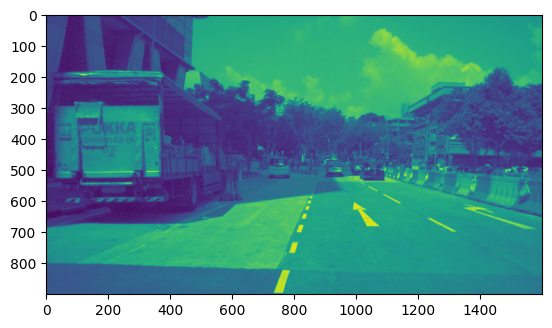

In [74]:
scene1=list(data.keys())[0]
img_t0=cv2.imread(data_path+"/"+ data[scene1][1]["image_list"][0],0)
img_t1=cv2.imread(data_path+"/"+data[scene1][2]["image_list"][0],0)
plt.imshow(img_t1)


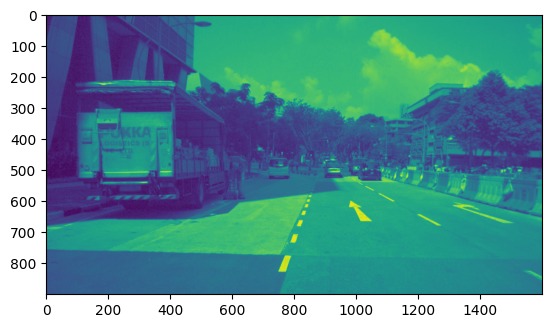

In [11]:
plt.imshow(img_t0)

(900, 1600, 2) (900, 1600, 3)


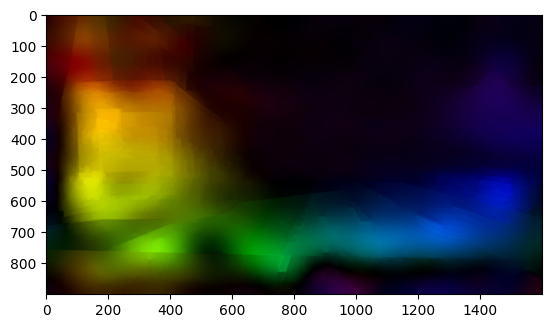

In [75]:
flow,rgb_flow= dense_optical_flow(img_t0,img_t1,img_vis=True)
print(flow.shape,rgb_flow.shape)
plt.imshow(rgb_flow)


In [76]:
print("Data Frame Time Diff",(data[scene1][7]['timestamp']-data[scene1][6]["timestamp"])/1e6)


Data Frame Time Diff 0.05


In [14]:
def resize_image(image, width, height):
    return cv2.resize(image, (width, height))

# Function to create a row of images
def create_row(images, width, height):
    resized_images = [resize_image(img, width, height) for img in images]
    return np.hstack(resized_images)

In [82]:


for i in range(len(data[scene1])-2):
    optical_flow_images=[]
    imgs_t0=[]
    imgs_t1=[]
    for j in range(len(data[scene1][i]["image_list"])):
        img_t0=cv2.imread(data_path+"/"+ data[scene1][i]["image_list"][j],0)
        img_t1=cv2.imread(data_path+"/"+data[scene1][i+1]["image_list"][j],0)
        flow,rgb_flow= dense_optical_flow(img_t0,img_t1,img_vis=True)
        optical_flow_images.append(rgb_flow)
        imgs_t0.append(np.dstack([img_t0,img_t0,img_t0]))
        imgs_t1.append(np.dstack([img_t1,img_t1,img_t1]))
    num_images = 6
    image_width = 200  # Adjust as needed
    image_height = 200  # Adjust as needed

    # Create rows
    row_t0 = create_row(imgs_t0, image_width, image_height)
    row_t1 = create_row(imgs_t1, image_width, image_height)
    row_flow = create_row(optical_flow_images, image_width, image_height)

    # Stack rows vertically to form a grid
    final_grid = np.vstack([row_t0, row_t1, row_flow])
    
    cv2.imwrite("./results/image_grid{}.jpg".format(i), final_grid) # update this file path to change directory of writing results 
    
    
        
        
        

KeyboardInterrupt: 

In [15]:

# Sparse Optical Flow using Lucas-Kanade method
def sparse_optical_flow(img1, img2,img_vis=False):
    feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
    lk_params = dict(winSize=(15, 15), maxLevel=2,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    p0 = cv2.goodFeaturesToTrack(img1, mask=None, **feature_params)
    p1, st, err = cv2.calcOpticalFlowPyrLK(img1, img2, p0, None, **lk_params)
    #print(p1.shape,st.shape,err.shape)
    # Draw the tracks
    mask = np.zeros_like(cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR))
    flow = np.zeros_like(np.dstack([img1,img1]))
    
    for i, (new, old) in enumerate(zip(p1[st == 1], p0[st == 1])):
        a, b = new.ravel()
        c, d = old.ravel()
        flow[int(d),int(c),0]= a-c
        flow[int(d),int(c),1]= b-d
            
        mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color=(255, 255, 0), thickness=3)
        mask = cv2.circle(mask, (int(c), int(d)), 10, color=(255, 0, 0), thickness=-1)
    return flow,mask
    

(900, 1600, 2) (900, 1600, 3)


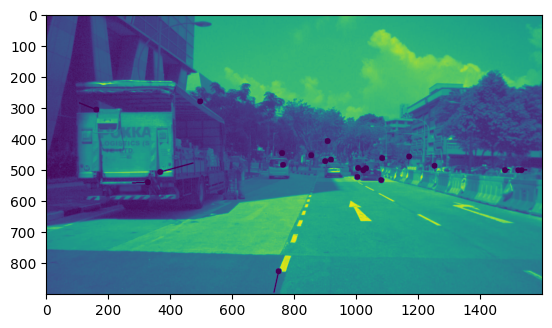

In [16]:
flow,mask= sparse_optical_flow(img_t0,img_t1,img_vis=True)
bin_mask=np.where(mask[:,:,0]>0,False,True)
print(flow.shape,mask.shape)
plt.imshow(bin_mask*img_t0)

In [17]:
# Write code for optical of each image

# Function 
"""_summary_
    input: 
    images_t0 : K_cameras, H,W
    mages_t1 : K_cameras, H,W
    output K_images,N_flow_vector,2  where N_flow_vectors : H*W  if dense optical flow of the image else N_flow_vectors< W*H else  sparese optical flow 
"""
def compute_optical_flow(images_t0,images_t1, dense=False,vis=True,data_path=""):
    """_summary_

    Args:
        images_t0 (_type_): _description_
        images_t1 (_type_): _description_
        dense (bool, optional): _description_. Defaults to False.
    """
    flows=None
    masks=None
    for img1_name, img2_name in zip(images_t0,images_t1):
        img_t0 =cv2.imread(os.path.join(data_path,img1_name),0)
        img_t1 =cv2.imread(os.path.join(data_path,img2_name),0)
        
        if dense:
            flow,mask=dense_optical_flow(img_t0,img_t1,vis)
            #print("In Dense",flow.shape)
        else:
            flow,mask=sparse_optical_flow(img_t0,img_t1,vis)
        
        if flows is not None:
            flows=np.concatenate((flows,flow[np.newaxis,...]),axis=0)
            if vis:
                masks=np.concatenate((flows,flow[np.newaxis,...]),axis=0)
        else:
            flows=flow[np.newaxis,...]
            
            if vis:
                mask=mask[np.newaxis,...]
           
    return flows,masks

In [18]:
flows,masks=compute_optical_flow(data[scene1][0]["image_list"],data[scene1][1]["image_list"],dense=True,data_path="/home/parth/Desktop/NortheasternCourses/MobileRobotics/FinalProject/Multicam_EgoMotion/nuscenes_mini")
flows.shape

(6, 900, 1600, 2)

In [19]:
#Prepocessing or utility 

#Dunction convert poitns from pixel plane to normalized camera frame

import numpy as np
def optical_flow_to_normalized_plane_multiple_cameras(flow, intrinsic_matrices):
    """
    Converts optical flow to the normalized image plane for multiple cameras.

    Parameters:
        flow (numpy.ndarray): Optical flow array of shape (K, H, W, 2), where:
                              - K is the number of cameras.
                              - H, W are the image dimensions.
                              - 2 represents horizontal and vertical flow components.
        intrinsic_matrices (numpy.ndarray): Intrinsic matrices of shape (K, 3, 3), where:
                                            - K is the number of cameras.
                                            - Each 3x3 matrix corresponds to the intrinsic parameters.

    Returns:
        numpy.ndarray: Normalized optical flow array of shape (K, H, W, 2).
    """
    # Validate input dimensions
    if len(flow.shape) != 4 or len(intrinsic_matrices.shape) != 3:
        raise ValueError("Flow must have shape (K, H, W, 2) and intrinsics (K, 3, 3).")
    if flow.shape[0] != intrinsic_matrices.shape[0]:
        raise ValueError("Number of cameras in flow and intrinsics must match.")
    
    # Extract dimensions
    K, H, W, _ = flow.shape

    # Prepare outputs
    normalized_flow = np.zeros_like(flow)
    normalized_coords = np.zeros_like(flow)

    # Loop through each camera to process flow and intrinsics
    for i in range(K):
        # Get intrinsic matrix for the current camera
        intrinsic_matrix = intrinsic_matrices[i]
        K_inv = np.linalg.inv(intrinsic_matrix)
        
        # Create grid of pixel coordinates for the current image
        x_coords, y_coords = np.meshgrid(np.arange(W), np.arange(H))
        ones = np.ones_like(x_coords)

        # Homogeneous pixel coordinates
        pixel_coords = np.stack((x_coords, y_coords, ones), axis=-1)  # Shape: (H, W, 3)
        pixel_coords_flat = pixel_coords.reshape(-1, 3)  # Shape: (H*W, 3)

        # Transform pixel coordinates to normalized coordinates
        normalized_coords_flat = (K_inv @ pixel_coords_flat.T).T  # Shape: (H*W, 3)
        normalized_coords[i,...] = normalized_coords_flat[:, :2].reshape(H, W, 2)  # Shape: (H, W, 2)
        

        # Normalize optical flow for this camera
        #dx_normalized = flow[i, ..., 0] / intrinsic_matrix[0, 0]  # Horizontal flow / fx
        #dy_normalized = flow[i, ..., 1] / intrinsic_matrix[1, 1]  # Vertical flow / fy
        dx_normalized = (flow[i, ..., 0] ) / intrinsic_matrix[0, 0]  # Horizontal flow
        dy_normalized = (flow[i, ..., 1]) / intrinsic_matrix[1, 1] 
        
        normalized_flow[i, ..., 0] = dx_normalized
        normalized_flow[i, ..., 1] = dy_normalized

    return normalized_coords,normalized_flow
 

In [20]:
normalized_coords,normalized_flow=optical_flow_to_normalized_plane_multiple_cameras(flows,intrinsic_matrices=np.array(data[scene1][0]["intrinsics"]))
print(normalized_coords.shape,normalized_flow.shape)

(6, 900, 1600, 2) (6, 900, 1600, 2)


In [21]:
#!pip install theseus-ai

In [21]:
import torch
import theseus as th
#IGNORE THE THESEUS PART 

In [396]:
print(th.__version__)

In [31]:
# TODO ( PARTH ) : WRITE GETTER AND SETTERS 
class MultiCamEgoMotion(object):
    def __init__(self):
    
        #super().__init__(self)
        self.flow = None  # [K, H, W, 2]
        self.normalized_coords = None # [K, H, W, 2]
        self.R_k_list = None  # [K, 3, 3]
        self.b_k_list = None  # [K, 3]
        self.degenrate_case=False
        self.M = torch.zeros((3, 3))
        self.mi = None # [K, H, W, 3]
        self.hk= None
        self.c = torch.zeros((3))
        #self.w = torch.zeros((3))a
        self.t = torch.zeros((3))
        self.w_=torch.zeros((3))

    def compute_data(self,normalized_coords, flows, Extriniscs,w):
         # Extract optimization variable w
        
        if self.mi is None:
            self.mi = torch.zeros(torch.concat([normalized_coords,normalized_coords[...,:1]],axis=-1).shape,dtype=torch.float32) # [K, H, W, 3]
            self.hk =torch.zeros(torch.as_tensor(Extriniscs[:,3,0:3]).shape,dtype=torch.float32) #K,3 dims of bk and hk match but serve diff purpose 
        self.flow = flows  # [K, H, W, 2]
        self.normalized_coords = normalized_coords # [K, H, W, 2]
        self.R_k_list = torch.as_tensor(Extriniscs[:,0:3,0:3],dtype=torch.float32)  # [K, 3, 3]
        self.b_k_list = torch.as_tensor(Extriniscs[:,:3,3],dtype=torch.float32)  # [K, 3]
        self.w_=w # [3,1]
        
        #print("flow",flow.shape)
        #print("normalized_coords",normalized_coords.shape)
        #print("R_k_list",self.R_k_list.shape)
        #print("flb_k_listow",self.b_k_list.shape)
        #print("w_",self.w_.shape)
        
        # Initialize M and c
        M = torch.zeros((3, 3), dtype=torch.float32)
        c = torch.zeros((3,1), dtype=torch.float32)

        # Loop through all cameras
        for k in range(self.flow.shape[0]):  # Iterate over K cameras
            
            normalized_coords_k=self.normalized_coords[k] # [H, W, 2]
            flow_k=self.flow[k] # [H, W, 2]
            
            R_k = torch.asarray(self.R_k_list[k],dtype=torch.float32)  # [3, 3]
            b_k = self.b_k_list[k]  # [3]

            # Reconstruct 3D points assuming unit depth
            P_k = torch.cat([normalized_coords_k,torch.ones_like(normalized_coords_k[...,:1])],dim=-1)  # [H, W, 3]
            P_k_dot = torch.cat([flow_k, torch.zeros_like(flow_k[..., :1])], dim=-1)  # [H, W, 3]

            # Compute omega_k and h_k
            #print(R_k.shape)
            omega_k = torch.matmul(R_k.T, w.T).squeeze(-1)  # [3]
            #print("w shape:",w.shape,"b_k shape",b_k.shape)
            #print("w",w)
            #print("bk",b_k)
            h_k = torch.cross(w, b_k[None])  # [3]
            #print(omega_k[None,None,...].shape,P_k.shape)
            inst_rotation_action= torch.cross(omega_k[None,None].expand_as(P_k),P_k,dim=-1) # [None,None,3] X [H,W,3] -> [H,W,3] it is broaddcasted
            combined_flow = P_k_dot + inst_rotation_action # [H,W,3] + [H,W,3] -> [H,W,3] 
            
            influence_of_flow_on_a_point = torch.cross(P_k,combined_flow) # [H,W,3] X [H,W,3] -> [H,W,3] 
            #print(R_k[None,None].shape)
            tranformed_influence_in_ego_frame= torch.matmul(R_k[None,None],influence_of_flow_on_a_point[...,None]).squeeze(-1) # None,None,3,3  @ H,W,3 -> H,W,3
            # [H,W,3] @ [3,3].T = H,W,3 
            # Compute m_i for each pixel
            mki=tranformed_influence_in_ego_frame
            #print(mki.shape)
            temp_M=torch.einsum("ijk,ijl->kl", mki, mki) # output 3,3 matrix 
            M+=temp_M
            #print(temp_M.shape,c.shape,h_k.shape,torch.matmul(temp_M, h_k.T).squeeze(-1).shape)
            c += -1 * torch.matmul(temp_M, h_k.T)
            self.mi[k]=mki
            self.hk[k]=h_k
        
        self.M=M
        self.c=c
        
        self.t=self.compute_optimal_t(M,c)
        
        return self.mi , self.c , self.M ,self.hk ,self.t
    
    def compute_optimal_t(self,M,c):
        return torch.matmul(torch.linalg.pinv(M),c)
    
    def is_degenarate(self,M,epsilon=1e-6):
        return torch.abs(torch.linalg.det(M)) < epsilon
    

In [32]:
#TESTING functions
obj=MultiCamEgoMotion()
obj.compute_data(torch.zeros((6,400,600,2)),torch.zeros((6,400,600,2)),torch.ones((6,4,4)),torch.zeros((1,3)))
print(obj.is_degenarate(obj.M))
print(obj.compute_optimal_t(obj.M,obj.c))

tensor(True)
tensor([[0.],
        [0.],
        [0.]])


/tmp/ipykernel_18236/1731316487.py:60: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:62.)
  h_k = torch.cross(w, b_k[None])  # [3]


In [28]:
from torch.autograd.functional import jacobian
torch.manual_seed(1)
size = 4096

In [34]:
#Theseus Solver Giving Issues 


# Define a custom cost function for J1(w)
class J1CostFunction(th.CostFunction,MultiCamEgoMotion):
    def __init__(self, name,normalized_coords,flows,Extriniscs,cost_weight,w):
        """
        Args:
            flow_images (torch.Tensor): Optical flow images of shape [K, H, W, 2].
            R_k_list (list[torch.Tensor]): List of rotation matrices for each camera.
            b_k_list (list[torch.Tensor]): List of translation vectors for each camera.
            t (torch.Tensor): Translational velocity vector.
        """
        self.cost_weight = th.ScaleCostWeight(1.0)
        th.CostFunction.__init__(self, name=name, cost_weight=self.cost_weight)
        MultiCamEgoMotion.__init__(self)
        
        self.w =w
        self.register_optim_vars(["w"])
        
        self.normalized_coords=normalized_coords
        self.flow=flows
        self.Extriniscs=Extriniscs
        self.w_tensor=w.tensor
        
    
    def dim(self):
        """
        Return the dimensionality of the cost function.
        """
        # Example: return dimensionality of the input variable w
        return 3

    def jacobians(self):
        """
        Compute the Jacobian matrix of the cost function using PyTorch autograd.
        """
        #w = self.w
        #w = w.tensor.requires_grad_(True)  # Enable gradient computation for w

        # Compute the error
        
        with torch.enable_grad():
            J1 = self.error()
            
            #print(J1)

        
            grad = torch.autograd.grad(J1, self.w_tensor, retain_graph=False, allow_unused=False)
            print(grad)
        
        
        return grad[0], J1  # Directly return the gradient wrt w


    def _copy_impl(self, new_name):
        """
        Creates a copy of this cost function object.
        """
        return J1CostFunction(
            new_name,
            self.normalized_coords.clone(),
            self.flow.clone(),
            self.Extriniscs.clone(),
            self.cost_weight.copy(),self.w.copy()
        )

    def error(self):
        """
        Compute the residual error for J1(w).
        """
        # Extract optimization variable w
        w = self.w
        w.tensor.g
        self.w_tensor = w.tensor.requires_grad_(True)
        
        mi ,c , M, hk , t = self.compute_data(self.normalized_coords, self.flow, self.Extriniscs,self.w_tensor)
        
        if self.is_degenarate(M):
            self.degenrate_case=True 
        
        print(self.degenrate_case)
        #print("M is ", M)
        #print(c)
        M_reg = M + 1e-6 * torch.eye(M.size(-1), device=M.device)
        
        
        J1 = -1 * torch.dot(c.squeeze(-1), torch.matmul(torch.linalg.pinv(M_reg), c).squeeze(-1))
        J1 = torch.sum((mi * hk[:, None, None, :]).sum(dim=-1) ** 2)# mi- K,H,W,3  , hk :K,3
                
        return J1


In [35]:


# Solver Function
def solve_ego_motion_single_time_step(images_t0,images_t1,Extrinsics,Intrinsics, w_init):
    """
    Solve the ego-motion estimation problem using Theseus with image format [K, H, W, 2].
    """
    # Convert inputs to PyTorch tensors
    #np_img_t0=np.array([cv2.imread(img_name,0) for img_name in images_t0])
    #np_img_t1=np.array([[cv2.imread(img_name,0) for img_name in images_t1]])
    flow_images,_=compute_optical_flow(images_t0,images_t1,dense=True,vis=True,data_path="/home/parth/Desktop/NortheasternCourses/MobileRobotics/FinalProject/Multicam_EgoMotion/nuscenes_mini")
    normalized_coords,normalized_flow = optical_flow_to_normalized_plane_multiple_cameras(flow_images, np.array(Intrinsics))
    #flow_images = torch.tensor(flow_images, dtype=torch.float32) # [K, H, W, 2].
    normalized_flow=normalized_flow /0.05
    
    Extrinsics = torch.tensor(Extrinsics, dtype=torch.float32) #[K,4,4]
    Intrinsics = torch.tensor(Intrinsics, dtype=torch.float32)
    w_init = torch.tensor(w_init, dtype=torch.float32) # [3]
    normalized_coords =torch.tensor(normalized_coords, dtype=torch.float32)
    normalized_flow = torch.tensor(normalized_flow,dtype=torch.float32)

    # Define optimization variable
    print(w_init.shape)
    w = th.Vector(tensor=w_init, name="w")
    #w.tensor = w_init
    
    

    # Create the J1 cost function
    j1_cost = J1CostFunction(
        name="J1",
        normalized_coords=normalized_coords,
        flows=normalized_flow,
        Extriniscs=Extrinsics,
        cost_weight = 1,
        w=w
    )

    # Create the objective
    objective = th.Objective()
    objective.add(j1_cost) 
    
    theseus_inputs = {"w":w_init}
    objective.update(theseus_inputs)
    
    
    print("Batch size:", objective.batch_size)
    print("Cost weight:", j1_cost.cost_weight)
    print("Optim vars:", j1_cost.optim_vars)
    optimizer = th.LevenbergMarquardt(
    objective,
    linear_solver_cls=th.LUDenseSolver,
    linearization_cls=th.DenseLinearization,
    max_iterations=50,
    step_size=0.5,
    damping=0.1
    )



    # Solve the optimization problem
    optimizer.optimize(
       max_iterations=5,  # Maximum iterations
       verbose=True,  # Print optimization progress
    )

    print(j1_cost.M)
    print(j1_cost.c)
    t_optimal=j1_cost.compute_optimal_t(j1_cost.M,j1_cost.c).detach().numpy()
    w_optimal= w.tensor.detach()
        
        
    
    # # Return the optimized w
    return w_optimal , t_optimal




In [36]:
w_init=np.array([[0.004477957729250193, 0.02866952493786812, 0.017157725989818573]])
w_optimal, t_optimal=solve_ego_motion_single_time_step(data[scene1][0]["image_list"][:4],data[scene1][1]["image_list"][:3],data[scene1][0]["extrinsics"][:3],data[scene1][0]["intrinsics"][:3],w_init)
print("w_optimal",w_optimal,"t_optimal",t_optimal)

torch.Size([1, 3])
Batch size: 1
Cost weight: <theseus.core.cost_weight.ScaleCostWeight object at 0x7fe756aceed0>
Optim vars: <generator object TheseusFunction.optim_vars.<locals>.<genexpr> at 0x7fe7545a3f10>


/home/parth/anaconda3/lib/python3.11/site-packages/theseus/optimizer/optimizer.py:42: UserWarning: Vectorization is off by default when not running from TheseusLayer. Using TheseusLayer is the recommended way to run our optimizers.
  warnings.warn(


AttributeError: 'Tensor' object has no attribute 'g'

In [27]:
print(data[scene1][0]["vel"],data[scene1][0]["rotation_rate"])

[8.988725931436823, 0.0, 0.0] [0.004477957729250193, 0.02866952493786812, 0.017157725989818573]


In [28]:
print(data[scene1][0]["extrinsics"])

[array([[ 5.68477868e-03, -5.63666773e-03,  9.99967955e-01,
         1.70079119e+00],
       [-9.99983517e-01, -8.37115272e-04,  5.68014846e-03,
         1.59456324e-02],
       [ 8.05071338e-04, -9.99983763e-01, -5.64133364e-03,
         1.51095764e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]]), array([[-8.32929563e-01, -9.94603768e-06,  5.53379023e-01,
         1.55084775e+00],
       [-5.53304927e-01,  1.63788158e-02, -8.32817742e-01,
        -4.93404796e-01],
       [-9.05540984e-03, -9.99865858e-01, -1.36479031e-02,
         1.49574801e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]]), array([[-0.93477554,  0.01587584, -0.35488399,  1.0148781 ],
       [ 0.35507456,  0.0113705 , -0.93476883, -0.48056822],
       [-0.01080503, -0.99980932, -0.01626597,  1.56239545],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), array([[ 0.00242171, -0.01675361, -0.99985672,  0.02832603],
       [

In [55]:
#PYTORCH SOLVER PART ( USE THIS INSTEAD OF THESEUS )
import torch
import torch.optim as optim

def solve_ego_motion_pytorch(images_t0, images_t1, Extrinsics, Intrinsics, w_init, max_iterations=10, learning_rate=0.001):
    """
    Solve the ego-motion estimation problem using PyTorch to optimize w.
    """
    # Compute optical flow and preprocess input
    flow_images, _ = compute_optical_flow(
        images_t0, images_t1, dense=True, vis=True,
        data_path=data_path
    )
    normalized_coords, normalized_flow = optical_flow_to_normalized_plane_multiple_cameras(
        flow_images, np.array(Intrinsics)
    )
    
    obj=MultiCamEgoMotion()

    
    Extrinsics = torch.tensor(Extrinsics, dtype=torch.float32)  # [K, 4, 4]
    Intrinsics = torch.tensor(Intrinsics, dtype=torch.float32)
    normalized_coords = torch.tensor(normalized_coords, dtype=torch.float32)
    normalized_flow = torch.tensor(normalized_flow, dtype=torch.float32)
    w = torch.tensor(w_init, dtype=torch.float32, requires_grad=True)

    
    optimizer = optim.Adam([w], lr=learning_rate,weight_decay=0.1)

    
    def compute_loss(w):
        """
        Custom loss function that computes the cost based on J1.
        """
        mi ,c , M, hk , t= obj.compute_data(normalized_coords, normalized_flow, Extrinsics, w)
        M_reg = M + 1e-6 * torch.eye(M.size(-1), device=M.device) # For numerical stability 
        
        print("Is degenerate:", obj.is_degenarate(M))
        
        
        J1 = -1 * torch.dot(c.squeeze(-1), torch.matmul(torch.linalg.pinv(M), c).squeeze(-1))
        J1 += torch.sum((mi * hk[:, None, None, :]).sum(dim=-1) ** 2)# mi- K,H,W,3  , hk :K,3
                
        return J1

    
    for iteration in range(max_iterations):
        optimizer.zero_grad()  # Reset gradients
        loss = compute_loss(w)  # Compute the loss
        loss.backward(retain_graph=True)  # Compute gradients
        optimizer.step()  # Update w

       
        if iteration % 5 == 0 or iteration == max_iterations - 1:
            print(f"Iteration {iteration}: Loss = {loss.item()}, w = {w.detach().numpy()}")

    
    t_optimal = obj.compute_optimal_t(obj.M,obj.c)
    print(obj.M,obj.c)
    

    # Return optimized w and t
    return w.detach().numpy(), t_optimal.detach().numpy()



In [68]:
w_init=np.array([[0.004477957729250193, 0.02866952493786812, 0.017157725989818573]])
w_optima_per_frame, t_optimal_per_frame=solve_ego_motion_pytorch(data[scene1][1]["image_list"][:],data[scene1][2]["image_list"][:],data[scene1][0]["extrinsics"][:],data[scene1][0]["intrinsics"][:],w_init,max_iterations=10)
print("w_optimal",w_optima_per_frame,"t_optimal",t_optimal_per_frame)


Is degenerate: tensor(False)
Iteration 0: Loss = 0.8742122650146484, w = [[0.00347796 0.02766952 0.01615773]]
Is degenerate: tensor(False)
Is degenerate: tensor(False)
Is degenerate: tensor(False)
Is degenerate: tensor(False)
Is degenerate: tensor(False)
Iteration 5: Loss = 0.566650390625, w = [[0.0027239  0.02271959 0.01139392]]
Is degenerate: tensor(False)
Is degenerate: tensor(False)
Is degenerate: tensor(False)
Is degenerate: tensor(False)
Iteration 9: Loss = 0.38701534271240234, w = [[0.00186411 0.01888994 0.00817056]]
tensor([[  733.1455,   282.3818,   -47.1807],
        [  282.3818,  2683.5291,  1520.7837],
        [  -47.1807,  1520.7837, 12685.4219]], grad_fn=<AddBackward0>) tensor([[-39.8323],
        [  2.2418],
        [289.1993]], grad_fn=<AddBackward0>)
w_optimal [[0.00186411 0.01888994 0.00817056]] t_optimal [[-0.05004609]
 [-0.00720191]
 [ 0.02347502]]


In [70]:
dt=0.1
t_optimal_dt = t_optimal_per_frame/dt 
w_optimal_dt = w_optima_per_frame/dt
print("vel_optimal",t_optimal.T, "w_optimal",w_optimal)

vel_optimal [[-0.5004609  -0.07201906  0.23475024]] w_optimal [[0.01864111 0.18889943 0.08170564]]


In [50]:
samples=1
for i in range(samples):
    print("velocity", data[scene1][i]["vel"]," roation rate",data[scene1][i]["rotation_rate"],(data[scene1][i+1]["timestamp"]-data[scene1][i]["timestamp"])/1e6)
# print(data[scene1][1]["vel"],data[scene1][1]["rotation_rate"])

# print(data[scene1][5]["vel"],data[scene1][5]["rotation_rate"])


velocity [8.988725931436823, 0.0, 0.0]  roation rate [0.004477957729250193, 0.02866952493786812, 0.017157725989818573] 0.05


In [66]:
print("Delta Translation",t_optimal[0]-data[scene1][i]["vel"],"Delta Rotation",w_optimal[0]-data[scene1][i]["rotation_rate"])

Delta Translation [-9.48918685 -0.50046092 -0.50046092] Delta Rotation [0.01416315 0.1602299  0.06454792]


In [180]:
import numpy as np
import matplotlib.pyplot as plt

def rmse_error(x_pred, x_gt):
    """
    Calculate the Root Mean Square Error (RMSE) between predicted and ground truth values.

    Parameters:
    x_pred (np.ndarray): Predicted values with shape [dynamic_shape, 3].
    x_gt (np.ndarray): Ground truth values with shape [dynamic_shape, 3].

    Returns:
    float: RMSE value.
    """
    if x_pred.shape != x_gt.shape:
        raise ValueError("Shapes of x_pred and x_gt must match")

    rmse = np.sqrt(np.mean((x_pred - x_gt) ** 2))
    return rmse

def distribution_error(x_pred, x_gt, num_bins=10):
    """
    Calculate the distribution error by binning the absolute differences.

    Parameters:
    x_pred (np.ndarray): Predicted values with shape [dynamic_shape, 3].
    x_gt (np.ndarray): Ground truth values with shape [dynamic_shape, 3].
    num_bins (int): Number of bins for the histogram.

    Returns:
    tuple: A tuple containing two arrays: bin edges and values.
    """
    if x_pred.shape != x_gt.shape:
        raise ValueError("Shapes of x_pred and x_gt must match")

    abs_diff = np.linalg.norm(x_pred - x_gt, axis=1)
    hist, bin_edges = np.histogram(abs_diff, bins=num_bins, density=True)
    return bin_edges, hist

def plot_distributions(bin_edges, hist_values, title="Distribution Error", xlabel="Error", ylabel="Frequency"):
    """
    Plot the error distributions.

    Parameters:
    bin_edges (np.ndarray): Edges of the bins.
    hist_values (np.ndarray): Values corresponding to each bin.
    title (str): Title of the plot.
    xlabel (str): Label for the x-axis.
    ylabel (str): Label for the y-axis.
    """
    plt.figure(figsize=(8, 5))
    plt.bar(bin_edges[:-1], hist_values, width=np.diff(bin_edges), align="edge", alpha=0.7, edgecolor="black")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()



RMSE: 0.4120841815513009


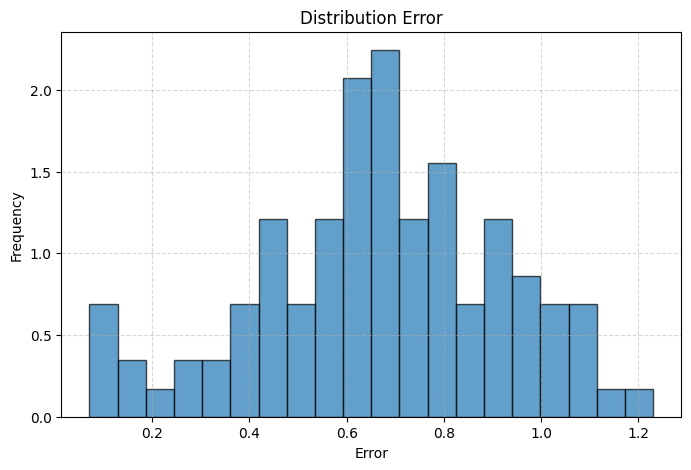

In [183]:

x_pred = np.random.rand(100, 3)
x_gt = np.random.rand(100, 3)
rmse = rmse_error(x_pred, x_gt)
print("RMSE:", rmse)
bin_edges, hist_values = distribution_error(x_pred, x_gt, num_bins=20)
plot_distributions(bin_edges, hist_values)

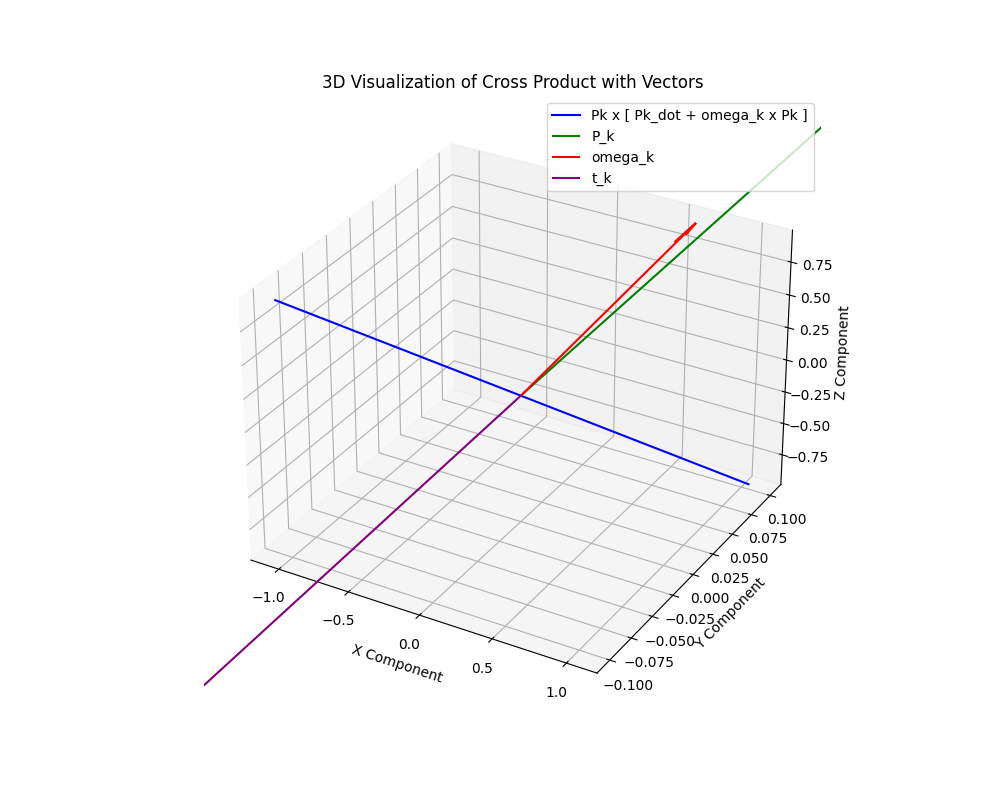

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def compute_cross_product(P_k, P_k_dot, omega_k):
    # Compute cross products
    cross_omega_Pk = np.cross(omega_k, P_k)
    inner_term = P_k_dot + cross_omega_Pk
    cross_Pk_inner = np.cross(P_k, inner_term)
    return cross_Pk_inner

def compute_Pk_dot(P_k, omega_k, t_k):
    # Compute P_k_dot using equation (3): P_k_dot = -omega_k x P_k - t_k
    cross_omega_Pk = np.cross(omega_k, P_k)
    P_k_dot = -cross_omega_Pk - t_k
    return P_k_dot

# Define example vectors
P_k = np.array([1.2, -3.1, 1.0])      # Example 3D point
omega_k = np.array([0.1, 0.2, 0.3])  # Angular velocity
t_k = np.array([0.5, -0.5, 0.5])     # Translational velocity

# Compute P_k_dot using the equation
P_k_dot = compute_Pk_dot(P_k, omega_k, t_k)

# Define a range of scalar multipliers for visualization
t_values = np.linspace(-1, 1, 100)

# Compute results for the cross product in each case
results = np.array([compute_cross_product(P_k, P_k_dot, omega_k) * t for t in t_values])
#print(results)
#print(t_values)

# Extract x, y, z components for 3D plotting
x_values = results[:, 0]
y_values = results[:, 1]
z_values = results[:, 2]

# Plot the 3D results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the cross product
ax.plot(x_values, y_values, z_values, label='Pk x [ Pk_dot + omega_k x Pk ]', color='blue')

# Add vectors P_k, omega_k, and t_k to the plot
origin = np.array([0, 0, 0])
ax.quiver(*origin, *P_k, color='green', label='P_k', arrow_length_ratio=0.1)
ax.quiver(*origin, *omega_k, color='red', label='omega_k', arrow_length_ratio=0.1)
ax.quiver(*origin, *t_k, color='purple', label='t_k', arrow_length_ratio=0.1)

# Set labels and title
ax.set_title('3D Visualization of Cross Product with Vectors')
ax.set_xlabel('X Component')
ax.set_ylabel('Y Component')
ax.set_zlabel('Z Component')
ax.legend()
plt.show()
